## 1. Install dependences and load data

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
import matplotlib
from PIL import Image

In [2]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# Avoid OutOfMemory error | I do not have a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Get all attributes of image_dataset_from_directory
tf.keras.utils.image_dataset_from_directory??

In [5]:
# Define the paths to the train and test directories
train_dir = '/content/drive/MyDrive/ml_project/data/train'
test_dir = '/content/drive/MyDrive/ml_project/data/test'

# with keras.utils we do not have to code the labels, and it preprocesses
## These build the data pipeline
train = tf.keras.utils.image_dataset_from_directory(train_dir,)
test = tf.keras.utils.image_dataset_from_directory(test_dir)
# if I add color_mode = 'grayscale' pictures appear blue/yello, idk y

# train and test are NOT preloaded, they are generators.
# we first convert into a numpy iterator

Found 4733 files belonging to 2 classes.
Found 1194 files belonging to 2 classes.


In [6]:
# with iterators we can access the generator from the data pipeline
## These allow to access the data pipeline
train_iterator = train.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [8]:
# gets another batch from the iterator
## Accessing the data pipeline itself
train_batch = train_iterator.next()
test_batch = test_iterator.next()


In [9]:
#the batches have len = 2, 1 is image representation, 2 is the label
print(len(train_batch))
train_batch[1] # dogs or muffins?

2


array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [10]:
print(train_batch[0].shape)
# images represented as numpy arrays
# batch size is 32, last one (3) are the channels (rgb)
# if I put color_mode = 'grayscale' when using tf.keras.utile.image_from_dataset
# I get just one "channel", so last element of the tuple is 1.

(32, 256, 256, 3)


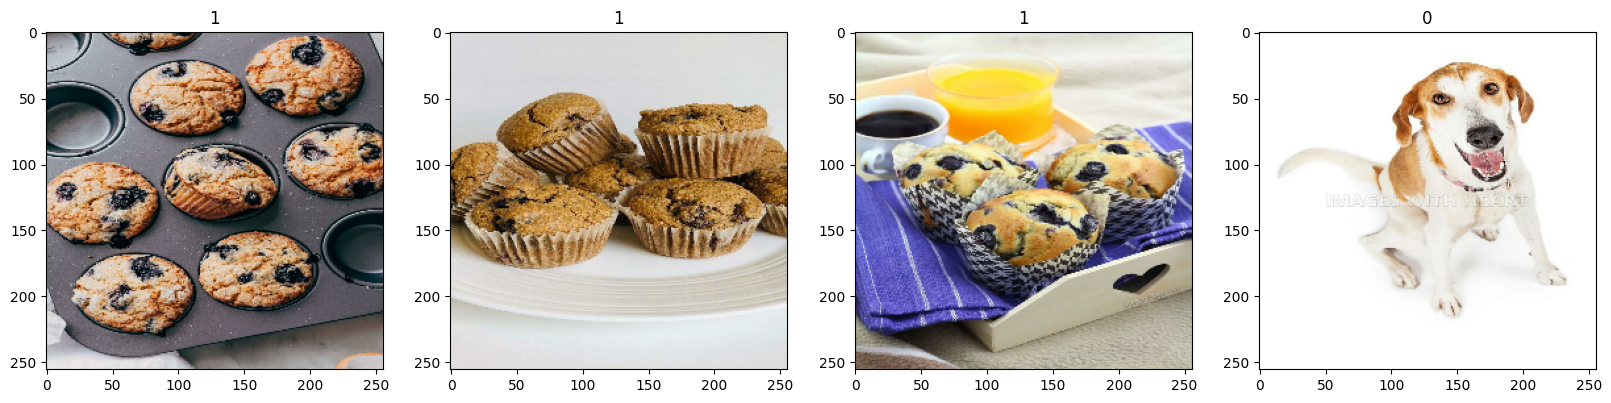

In [11]:
# visualize the images. They have the correct colors!
# 1 is muffins, 0 is chihuahuas
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(train_batch[1][idx])

## Data Processing
- Resize all images -> already done
- Bring everything to greyscale -> already done

In [ ]:
# shape of each image
print(train_batch[0].shape)
print(train_batch[0].min())
print(train_batch[0].max()) # we want values as small as possible -> /255
# this makes optimization more efficient -> we need to scale values

In [ ]:
# we implement the data transformation in the pipeline
# x represent images, y labels
train = train.map(lambda x,y: (x/255,y))
test = test.map(lambda x,y: (x/255,y))


In [ ]:
scaled_iterator = train.as_numpy_iterator()
scaled_iterator_test = test.as_numpy_iterator()

In [ ]:
train_batch = scaled_iterator.next()
test_batch = scaled_iterator_test.next()

In [ ]:
# check the values of the images
print(f"Min value of scaled images: {train_batch[0].min()}")
print(f"Max value of scaled images: {train_batch[0].max()}")

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img)  # Matplotlib uses default colormap
    ax[idx].axis('off')  # Turn off axis
    ax[idx].title.set_text(train_batch[1][idx])

plt.show()

## Create Validation Data

In [ ]:
print(len(train)) # we have 148 batches
train_size = int(len(train)*0.8)
val_size = int(len(train)*0.2) + 1 # + 1 otherwise 1 is missing

print(train_size)
print(val_size)

In [ ]:
train_data = train.take(train_size)
val_data = train.skip(train_size).take(val_size)

In [ ]:
print(f"len(train) = {len(train_data)}")
print(f"len(val) = {len(val_data)}")
print(f"Length of initial data = {len(train)} = {len(train_data) + len(val_data)}")

## Build the Model

In [ ]:
from tensorflow.keras.models import Sequential # good with 1 input 1 output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
# initialize the first model
model = Sequential()

In [ ]:
# first layer must be input layer or have an imput
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape = (256,256,3)))
# 16 is the number of filers, each filter is 3x3 pixels, 1 is the stride
model.add(MaxPooling2D())
# this takes the maximum value after the relu and returns it
# check MaxPooling2D?? for each 2x2 region (pool) takes the highest value

model.add(Conv2D(32, (3,3), 1, activation='relu')) # now 32 filters
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
# When we apply the conv layer the filters are going to be the last channel.
# We condense the length and width, then the number of filters will form the
# channel value. When we pass values to the dense layer we don't want multiple
# values, but we want to 'flatten' them in a single value (thus the Flatten layer)

# dense layers are fully connected layers
model.add(Dense(256, activation='relu')) # 256 values as output.
model.add(Dense(1 ,activation='sigmoid')) # 1 output only, due to sigmoid




In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# we use binary cross entropy since it is a classification problem.

#tf.optimizers. to get all the optimizers

In [ ]:
model.summary()

## Train the model

In [ ]:
# create a log directory
logdir = 'logs'



In [ ]:
# this is going to log how the model trains as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
#.fit method -> training component
#.predict -> when we make the predictions
hist = model.fit(train_data,
                 epochs=20,
                 validation_data = val_data,
                 callbacks=[tensorboard_callback])

# This takes hours though..

## Evaluate Performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
# To use the metrics we need to establish instances of them
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in #scaled_iterator_test or test_batch IDK which one